![Dynamat Banner](docs/figures/banner.png)

# Split-Hopkinson Pressure Bar (SHPB) Numerical Analysis

Authors: [Erwin Cazares<sup>1</sup>](ecazares3@miners.utep.edu), </br>

Contributors: [Dr Brian E. Schuster<sup>1</sup>](bschuster@utep.edu), [David K Santacruz<sup>1</sup>](dksantacruz@miners.utep.edu) </br>

<sup>1</sup> Dynamic Materials Laboratory at the University of Texas at El Paso, TX USA 79968</br>

Date of creation: Fall 2024 </br>
Date of last revision: Spr 2025 </br>

In [21]:
import numpy as np
import pandas as pd
from scripts.rdf_wrapper import RDFWrapper
from scripts.SHPB_RDFSignalFetch import RawExperimentDataHandler
import plotly.graph_objects as go
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline
from numpy.linalg import norm
import pywt
import os, io
import glob

# Get the directory of the current script or the parent directory
script_dir = os.getcwd()
print(f'Current working directory = {script_dir}')

result_folder = os.path.join(script_dir, "results", "SS316_Mono")
experiment_name = "SS316_011"

Current working directory = E:\DynaMat_UTEP\SHPB_Toolkit


In [5]:
# Demo data under data_demo/**/*.txt files
data_files = glob.glob(os.path.join(script_dir, "data", "*.ttl"), recursive=True) 
print(f"Number of demo files : {len(data_files)} \n")
print(f"Last 10 files names:")
for idx, f_name in enumerate(data_files[-20:]):
    print(idx, f_name, "\n")

Number of demo files : 131 

Last 10 files names:
0 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250405_SS316_LAB_RT_007.ttl 

1 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250405_SS316_LAB_RT_008.ttl 

2 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250404_PULSE_LAB_RT_019.ttl 

3 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250404_PULSE_LAB_RT_020.ttl 

4 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250404_PULSE_LAB_RT_021.ttl 

5 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407_A356_LAB_RT_001.ttl 

6 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407_A356_LAB_RT_002.ttl 

7 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407_AL7075T6_LAB_RT_010.ttl 

8 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407_AL7075T6_LAB_RT_011.ttl 

9 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407_SS316_LAB_RT_009.ttl 

10 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407_SS316_LAB_RT_010.ttl 

11 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407_SS316A356_LAB_RT_001.ttl 

12 E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250407_SS316A356_LAB_RT_002.ttl 


In [6]:
# Select the desired data file
idx = -6 ### Change this!
print(f"Selected {data_files[idx]} for analysis \n")

experiment = RDFWrapper(data_files[idx])
handler = RawExperimentDataHandler(experiment)

# Fetch gauge signals
incident_gauge_signals = handler.fetch_gauge_signals("dynamat:IncidentSensorSignal")
transmitted_gauge_signals = handler.fetch_gauge_signals("dynamat:TransmittedSensorSignal")
time_sensor_signals = handler.fetch_sensor_signals("dynamat:TimeSensorSignal")

raw_data = pd.DataFrame({
  "Time": time_sensor_signals.iloc[:, 0], 
    "Incident Raw": incident_gauge_signals.iloc[:,0],
    "Transmitted Raw": transmitted_gauge_signals.iloc[:,0]
})

raw_data.info()

Selected E:\DynaMat_UTEP\SHPB_Toolkit\data\ECG_20250418_SS316_LAB_RT_011.ttl for analysis 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             160000 non-null  float32
 1   Incident Raw     160000 non-null  float32
 2   Transmitted Raw  160000 non-null  float32
dtypes: float32(3)
memory usage: 1.8 MB


In [7]:
# This variables must be changed for the specific test, see documentation for the metadata.

# Extract Test Metadata
testing_conditions_uri = experiment.get_instances_of_class("dynamat:TestingConditions")[0]
test_type = experiment.get_objects(testing_conditions_uri, "dynamat:hasTestType")[0].split("#")[-1]
test_mode = experiment.get_objects(testing_conditions_uri, "dynamat:hasTestMode")[0].split("#")[-1]
test_temperature = experiment.get_objects(testing_conditions_uri, "dynamat:hasTestTemperature")[0].split("#")[-1]
trap_condition = experiment.get_objects(testing_conditions_uri, "dynamat:hasMomentumTrap")[0].split("#")[-1]

print("Tetst Metadata")
print("-----"*10)
print(f"Test Type: {test_type}")
print(f"Test Mode: {test_mode}")
print(f"Test Temperature: {test_temperature}")
print(f"Momentum Trap Condition: {trap_condition}")

# Striker Conditions
striker_bar_uri = experiment.get_instances_of_class("dynamat:StrikerBar")[0]
striker_bar_material = experiment.get_objects(striker_bar_uri, "dynamat:hasMaterial")[0]
striker_bar_dimensions = experiment.get_objects(striker_bar_uri, "dynamat:hasDimension")
striker_bar_properties = experiment.get_objects(striker_bar_uri, "dynamat:hasMechanicalProperty")

for prop in striker_bar_dimensions:
    if "OriginalLength" in prop:
        striker_length = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm
    elif "Velocity" in prop:
        striker_velocity = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # m/s
    elif "OriginalCrossSectionalArea" in prop:
        bar_cross_section = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm^2
        bar_radius = np.sqrt(bar_cross_section / np.pi)
        
for prop in striker_bar_properties:
    if "Density" in prop:
        bar_density = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # kg/mm3
    elif "Poissons" in prop:
        bar_poissons = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # unitless
    elif "ElasticModulus" in prop:
        bar_elastic_modulus = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # MPa
    elif "WaveSpeed" in prop:
        bar_wave_speed = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # MPa
        
print("\n Striker Conditions")
print("-----"*10)
print(f"Striker Material: {striker_bar_material.split('#')[-1]}")
print(f"Stiker Length: {striker_length:.3f} mm")
print(f"Stiker Velocity: {striker_velocity:.3f} m/s or mm/ms")

print("\n Bar Material Properties")
print("-----"*10)
print(f"Bar Density: {bar_density:.3e} kg/mm^3")
print(f"Bar Posisson's Ratio: {bar_poissons}")
print(f"Bar Elastic Modulus: {bar_elastic_modulus:.3e} MPa")
print(f"Bar Wave Speed: {bar_wave_speed:.3f} m/s or mm/ms")
print(f"Bar Cross Section: {bar_cross_section:.3f} mm^2")
print(f"Bar Radius: {bar_radius:.3f} mm")

# Strain Gauge Distances
incident_bar_uri = experiment.get_instances_of_class("dynamat:IncidentBar")[0]
incident_strain_gauge = experiment.get_objects(incident_bar_uri, "dynamat:hasStrainGauge")[0]
incident_strain_gauge_dist = experiment.get_objects(incident_strain_gauge, "dynamat:hasDimension")[0]
incident_strain_gauge_dist = float(experiment.get_objects(incident_strain_gauge_dist, "dynamat:hasValue")[0])

transmitted_bar_uri = experiment.get_instances_of_class("dynamat:TransmittedBar")[0]
transmitted_strain_gauge = experiment.get_objects(transmitted_bar_uri, "dynamat:hasStrainGauge")[0]
transmitted_strain_gauge_dist = experiment.get_objects(transmitted_strain_gauge, "dynamat:hasDimension")[0]
transmitted_strain_gauge_dist = float(experiment.get_objects(transmitted_strain_gauge_dist, "dynamat:hasValue")[0])

print("\n Strain Gauge Distances")
print("-----"*10)
print(f"Incident Strain Gauge Distance: {incident_strain_gauge_dist:.3f} mm")
print(f"Transmitted Strain Gauge Distance: {transmitted_strain_gauge_dist:.3f} mm")

if test_type == "SpecimenTest": 
    specimen_data_uri = experiment.get_instances_of_class("dynamat:SHPBSpecimen")[0]
    specimen_material = experiment.get_objects(specimen_data_uri, "dynamat:hasMaterial")[0]
    specimen_dimensions = experiment.get_objects(specimen_data_uri, "dynamat:hasDimension")
    for prop in specimen_dimensions:
        if "OriginalLength" in prop:
            specimen_length = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm
        elif "DeformedLength" in prop:
            specimen_length_deformed = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm
        elif "OriginalCrossSectionalArea" in prop:
            specimen_cross = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm^2
        elif "DeformedCrossSectionalArea" in prop:
            specimen_cross_deformed = float(experiment.get_objects(prop, "dynamat:hasValue")[0]) # mm^2  
            
    print("\n Specimen Dimensions")
    print("-----"*10)
    print(f"Specimen Material: {specimen_material.split('#')[-1]}")
    print(f"Specimen Original Length: {specimen_length:.3f} mm")
    specimen_length = 6.36
    print(f"Specimen Deformed Length: {specimen_length_deformed:.3f} mm")
    print(f"Specimen Cross Section: {specimen_cross:.3f} mm^2")
    specimen_cross = 31.76904
    print(f"Specimen Deformed Cross Section: {specimen_cross_deformed:.3f} mm^2")

Tetst Metadata
--------------------------------------------------
Test Type: SpecimenTest
Test Mode: LABMode
Test Temperature: RoomTemperature
Momentum Trap Condition: MomentumTrapEngaged

 Striker Conditions
--------------------------------------------------
Striker Material: SteelC350
Stiker Length: 304.800 mm
Stiker Velocity: 34.080 m/s or mm/ms

 Bar Material Properties
--------------------------------------------------
Bar Density: 8.082e-06 kg/mm^3
Bar Posisson's Ratio: 0.29
Bar Elastic Modulus: 2.000e+05 MPa
Bar Wave Speed: 4953.321 m/s or mm/ms
Bar Cross Section: 71.251 mm^2
Bar Radius: 4.762 mm

 Strain Gauge Distances
--------------------------------------------------
Incident Strain Gauge Distance: 1219.200 mm
Transmitted Strain Gauge Distance: 1219.200 mm

 Specimen Dimensions
--------------------------------------------------
Specimen Material: SS316
Specimen Original Length: 6.360 mm
Specimen Deformed Length: 4.740 mm
Specimen Cross Section: 31.570 mm^2
Specimen Deformed 

In [8]:
strain_raw_fig = go.Figure()
        
strain_raw_fig.add_trace(go.Scatter(x=raw_data["Time"], y=raw_data["Incident Raw"], mode='lines', name='Incident', 
                                                        line=dict(color='royalblue', width=2)))
strain_raw_fig.add_trace(go.Scatter(x=raw_data["Time"], y=raw_data["Transmitted Raw"], mode='lines', name='Transmitted',
                                                        line=dict(color='red', width=2)))           
# Customize layout
strain_raw_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Converted Strain Signal vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=20, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Strain", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Strain Pulses", x=1.0, y=1.0, font=dict(size=12, color="black", family="Arial"),
                                         bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

        
# Display the interactive plot
fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)
strain_raw_fig.write_html(os.path.join(fig_path, f"{experiment_name}_signal_raw.html"), include_plotlyjs='cdn')
raw_data.to_csv(os.path.join(fig_path, f"{experiment_name}_primary_data.csv"))

# Stop for elastic!

In [9]:
# Determine Pulse Duration
delta_t = np.mean(np.diff(raw_data["Time"]))
print("\n Pulse Properties")
print("-----"*10)
print(f"Average Delta T: {delta_t:.3e} ms")

pulse_duration = (2*striker_length) / bar_wave_speed
print(f"Pulse Duration from Calibrated Bar Wave Speed: {pulse_duration:.3f} ms")

pulse_data_points = int(pulse_duration / delta_t) 
print(f"Pulse Data Points from Calibrated Bar Wave Speed: {pulse_data_points} points")

pulse_length = 2*striker_length
pulse_stress = (1/2) * bar_density * bar_wave_speed * striker_velocity * 1000
pulse_strain = (1/2) * (striker_velocity / bar_wave_speed)

print(f"Pulse Length: {pulse_length:.3f} mm")
print(f"Pulse Stress: {pulse_stress:.3f} MPa")
print(f"Pulse Strain: {pulse_strain:.3e} mm/mm")


 Pulse Properties
--------------------------------------------------
Average Delta T: 1.250e-05 ms
Pulse Duration from Calibrated Bar Wave Speed: 0.123 ms
Pulse Data Points from Calibrated Bar Wave Speed: 9845 points
Pulse Length: 609.600 mm
Pulse Stress: 682.200 MPa
Pulse Strain: 3.440e-03 mm/mm


In [10]:
def find_pulse_edges(edges, signal, pulse_window):
    """
    Identifies and classifies pulses using value-based sign tracking and validates pulse windows.
    Designed to separate overlapping pulses such as incident and reflected waves in SHPB data.
    
    Parameters:
    edges (array-like): List of detected edge indices.
    signal (array-like): The reference signal (e.g., SHPB strain gauge data).
    pulse_window (float): Expected pulse duration (in index units).
    
    Returns:
    tuple: (List of valid pulse start indices, Dictionary of all pulse properties)
    """
    rising_edges_start_idx = []
    falling_edges_start_idx = [] 
    window_start_approx = []
    window_end_approx = []
    
    edge_results = {
        "start": [],
        "end": [],
        "n_points": [],
        "direction": []
    }

    if len(edges) == 0:
        return window_start_approx, edge_results

    # Compute first derivative of the signal
    derivative = np.gradient(signal)
    
    edges = np.sort(edges)
    grouped_edges = []
    current_group = [edges[0]]
    current_sign = current_sign = np.sign(signal[edges[0]]) if signal[edges[0]] != 0 else 1

    for i in range(1, len(edges)):
        edge = edges[i]
        signal_sign = np.sign(signal[edge])

        # Start new group if sign of signal changes or if edge is too far from previous
        if signal_sign != current_sign or edge - edges[i - 1] > 2000:
            grouped_edges.append(current_group)
            current_group = [edge]
            current_sign = signal_sign
        else:
            current_group.append(edge)

    grouped_edges.append(current_group)

    # Analyze each group to determine direction and properties
    for group in grouped_edges:
        start_idx = group[0]
        end_idx = group[-1]
        n_points = len(group)
        avg_slope = np.mean(derivative[start_idx:end_idx])

        if avg_slope > 0: 
            direction = 1
            rising_edges_start_idx.append(start_idx)
        else: 
            direction = -1
            falling_edges_start_idx.append(start_idx)

        edge_results["start"].append(start_idx)
        edge_results["end"].append(end_idx)
        edge_results["n_points"].append(n_points)
        edge_results["direction"].append(direction)

    # Match rising and falling edges using window constraint
    for rise_idx in rising_edges_start_idx:
        valid_falls = [
            fall_idx for fall_idx in falling_edges_start_idx
            if pulse_window * 0.8 <= abs(rise_idx - fall_idx) <= pulse_window * 2.5
        ]

        if valid_falls:
            best_fall_idx = min(valid_falls, key=lambda x: abs(rise_idx - x))
            window_start_approx.append(min(rise_idx, best_fall_idx))
            window_end_approx.append(max(rise_idx, best_fall_idx))

    return window_start_approx, window_end_approx


In [11]:
# Define wavelet (Derivatives of Gaussians are good for edges)
wavelet = 'gaus1'
scales = np.arange(1, 300, 2)  # Multi-scale analysis

# Compute CWT
"""
segment1 = raw_data["Incident Raw"][0:50000]
segment2 = raw_data["Incident Raw"][75000:120000]
combined = np.concatenate([segment1, segment2])
incident_coeffs, _ = pywt.cwt(combined, scales, wavelet)
"""

incident_coeffs, _ = pywt.cwt(raw_data["Incident Raw"][:90000], scales, wavelet)
transmitted_coeffs, _ = pywt.cwt(raw_data["Transmitted Raw"][:90000], scales, wavelet)

# Find strong edges by taking the absolute max of wavelet coefficients
incident_edges = np.where(np.abs(incident_coeffs).max(axis=0) > np.percentile(np.abs(incident_coeffs), 96.0))[0]  ## 97.0
transmitted_edges = np.where(np.abs(transmitted_coeffs).max(axis=0) > np.percentile(np.abs(transmitted_coeffs), 98.5))[0]

# Find the approximate pulse start
incident_start_approx, incident_end_approx = find_pulse_edges(incident_edges, raw_data["Incident Raw"],
                                                              pulse_data_points)
transmitted_start_approx, transmitted_end_approx = find_pulse_edges(transmitted_edges, raw_data["Transmitted Raw"],
                                                                    pulse_data_points)

In [12]:
# Plot found edges on signals
edges_fig = go.Figure()
        
edges_fig.add_trace(go.Scatter(x=raw_data["Time"], y=raw_data["Incident Raw"], mode='lines', name='Incident', 
                                                        line=dict(color='royalblue', width=2)))
edges_fig.add_trace(go.Scatter(x=raw_data["Time"], y=raw_data["Transmitted Raw"], mode='lines', name='Transmitted',
                                                        line=dict(color='red', width=2))) 
# Add wavelet coefficient signals
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][incident_edges[::10]], y=raw_data["Incident Raw"][incident_edges[::10]], mode='markers',
                               marker=dict(color='green', size=6, symbol='circle'), name="Incident Edge"))
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][transmitted_edges[::10]], y=raw_data["Transmitted Raw"][transmitted_edges[::10]], mode='markers',
                               marker=dict(color='orange', size=6, symbol='circle'), name="Transmitted Edge"))

# Add approximate window start
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][incident_start_approx], y=raw_data["Incident Raw"][incident_start_approx], mode='markers',
                               marker=dict(color='purple', size=16, symbol='circle'), name="Approx Incident Start"))
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][incident_end_approx], y=raw_data["Incident Raw"][incident_end_approx], mode='markers',
                               marker=dict(color='darkturquoise', size=16, symbol='circle'), name="Approx Incident End"))
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][transmitted_start_approx], y=raw_data["Transmitted Raw"][transmitted_start_approx], mode='markers',
                               marker=dict(color='plum', size=16, symbol='circle'), name="Approx Transmitted Start"))
edges_fig.add_trace(go.Scatter(x=raw_data["Time"][transmitted_end_approx], y=raw_data["Transmitted Raw"][transmitted_end_approx], mode='markers',
                               marker=dict(color='salmon', size=16, symbol='circle'), name="Approx Transmitted End"))

# Customize layout
edges_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                        title=dict(text="Detected Edges on Raw Pulse Data", x=0.5, y=0.95, xanchor="center",
                                   font=dict(size=20, color="black", family="Arial")),
                        xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                   tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                   gridcolor="lightgrey", gridwidth=1),
                        yaxis=dict(title=dict(text="Voltage", font=dict(family="Arial", size=16, color="black")),
                                   tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                   gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                        legend=dict(title="Strain Pulses", x=1.0, y=1.0, font=dict(size=12, color="black", family="Arial"),
                                    bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

# Display the interactive plot
fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)
edges_fig.write_html(os.path.join(fig_path, f"{experiment_name}_edges.html"), include_plotlyjs='cdn')

In [120]:
int(-1.0)

-1

In [130]:
def extract_pulse_window(signal, signal_start_approx, signal_end_approx, pulse_points, pp_extra, tail, negative = True):
    
    search_range = np.arange(int(signal_start_approx-(pulse_points*pp_extra)),
                             int(signal_start_approx+(pulse_points*(1+pp_extra)))
                             ,1)
    
    signal_subset = np.array(signal[search_range])    
    signal_gradient = np.gradient(signal_subset)

    if negative:
        signal_start_slope = np.argmin(signal_gradient)
        
    else: 
        signal_start_slope = np.argmax(signal_gradient)
        
    signal_start_zero = np.where(np.isclose(signal_subset[:signal_start_slope], 0, atol=1e-5))[0][-1]
    try:
        signal_end_zero = np.where(np.isclose(signal_subset[signal_start_slope:], 0, atol=11e-5))[0][0]
    except:
        signal_end_zero = len(signal_subset)
        print("Using last subset idx as signal end")
    
    window_range = np.arange(int(signal_start_zero - tail), int(signal_start_slope + signal_end_zero + tail), 1)    
    try:
        extracted_signal = signal_subset[window_range]
    except:
        print("Tail window to large, starting at zero")
        extracted_signal = signal_subset[signal_start_zero:]  
        
        
    time_start_idx = int(signal_start_approx-(pulse_points*pp_extra) + signal_start_zero)
    
    return extracted_signal, time_start_idx


In [133]:
# Extract pulses from approximations
tail = pulse_data_points * 0.3
incident_extracted, incident_start = extract_pulse_window(raw_data["Incident Raw"], incident_start_approx[0],
                                                         incident_end_approx[0], pulse_data_points, 0.6, tail)
transmitted_extracted, transmitted_start = extract_pulse_window(raw_data["Transmitted Raw"], transmitted_start_approx[0],
                                                         transmitted_end_approx[0], pulse_data_points, 0.6, tail)
if test_type == "SpecimenTest":
    reflected_extracted, _ = extract_pulse_window(raw_data["Incident Raw"], incident_start_approx[2],
                                                             incident_end_approx[2], pulse_data_points, 0.40, tail, negative=False)

    subset_points = min(len(incident_extracted), len(reflected_extracted), len(transmitted_extracted))
    reflected_extracted = reflected_extracted[:subset_points]

else: 
    subset_points = min(len(incident_extracted), len(transmitted_extracted))

incident_extracted = incident_extracted[:subset_points]
transmitted_extracted = transmitted_extracted[:subset_points]

time = np.linspace(0, pulse_duration, subset_points)

# Determine Experiment Pulse Speed
print("\n Pulse Speed")
print("--------"*10)
if test_type == "SpecimenTest":
    pulse_speed = (incident_strain_gauge_dist + transmitted_strain_gauge_dist + specimen_length) / ((transmitted_start - incident_start ) * delta_t)
else:
    pulse_speed = (incident_strain_gauge_dist + transmitted_strain_gauge_dist) / ((transmitted_start - incident_start ) * delta_t)
    
print(f"Calculated Pulse Speed: {pulse_speed:.3f} mm/ms or m/s")

if test_type == "PulseTest":
    print(f"Wave Speed Difference from Bar Reference: {((bar_wave_speed - pulse_speed) / pulse_speed)* 100 :.3f} % ")
    pulse_duration = (2*striker_length) / pulse_speed
    print(f"New Pulse Duration: {pulse_duration:.3f} ms")

Using last subset idx as signal end
Tail window to large, starting at zero

 Pulse Speed
--------------------------------------------------------------------------------
Calculated Pulse Speed: 4862.895 mm/ms or m/s


In [134]:
extracted_fig = go.Figure()
        
extracted_fig.add_trace(go.Scatter(x=time, y=incident_extracted , mode='lines', name='Incident', 
                                                        line=dict(color='royalblue', width=2)))
extracted_fig.add_trace(go.Scatter(x=time, y=transmitted_extracted , mode='lines', name='Transmitted', 
                                                        line=dict(color='red', width=2)))
if test_type == "SpecimenTest":
    extracted_fig.add_trace(go.Scatter(x=time, y=reflected_extracted , mode='lines', name='Reflected', 
                                                            line=dict(color='green', width=2)))  
# Customize layout
extracted_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                            title=dict(text="Extracted Strain Signals vs Time", x=0.5, y=0.95, xanchor="center",
                                       font=dict(size=20, color="black", family="Arial")),
                            xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                       tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                       gridcolor="lightgrey", gridwidth=1),
                            yaxis=dict(title=dict(text="Strain", font=dict(family="Arial", size=16, color="black")),
                                       tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                       gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                            legend=dict(title="Strain Pulses", x=1.0, y=1.0, font=dict(size=12, color="black", family="Arial"),
                                        bgcolor="#FFFFFF", bordercolor="black", borderwidth=2))

        
# Display the interactive plot
# Display the interactive plot
fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)
extracted_fig.write_html(os.path.join(fig_path, f"{experiment_name}_extracted_pulse.html"), include_plotlyjs='cdn')

## Fit Pulse Windows

In [135]:
def fit_pulse_windows(pulses, threshold, negatives):
    """
    Trim a list of pulses based on a threshold so that each pulse starts at
    its own threshold crossing and is then trimmed to a common length.
    
    Parameters:
      pulses    : list or array of 1D arrays
                  Each element is a pulse (time-series data).
      threshold : float
                  The threshold value used for determining the pulse start.
      negative  : bool, default True
                  If True, the pulse start is defined as the first index 
                  where the pulse value is less than the threshold.
                  If False, the pulse start is defined as the first index 
                  where the pulse value is greater than the threshold.
    
    Returns:
      trimmed_pulses : list of 1D NumPy arrays
                       Each pulse is trimmed starting at its own threshold
                       crossing and continuing for a common length (the
                       minimum available length across pulses).
    """
    start_indices = []
    for idx, pulse in enumerate(pulses):
        # Ensure pulse is a NumPy array.
        pulse = np.array(pulse)
        
        if negatives[idx]:
            # Find indices where the pulse is below the threshold.
            indices = np.where(pulse < -threshold)[0]
        else:
            indices = np.where(pulse > threshold)[0]
        
        # If no index meets the criterion, we default to index 0.
        idx = indices[0] if len(indices) > 0 else 0
        start_indices.append(idx)
    
    # For each pulse, compute the number of points available after its start index.
    lengths_after = [len(pulse) - idx for pulse, idx in zip(pulses, start_indices)]
    common_length = min(lengths_after)
    
    # Now trim every pulse from its own start index to start index + common_length.
    trimmed_pulses = [np.array(pulse)[idx: idx + common_length]
                      for pulse, idx in zip(pulses, start_indices)]
    
    return trimmed_pulses


    

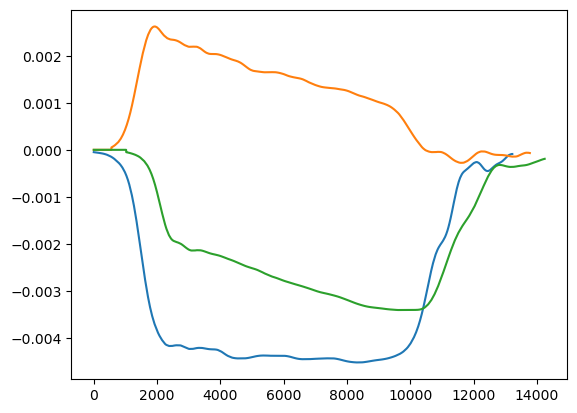

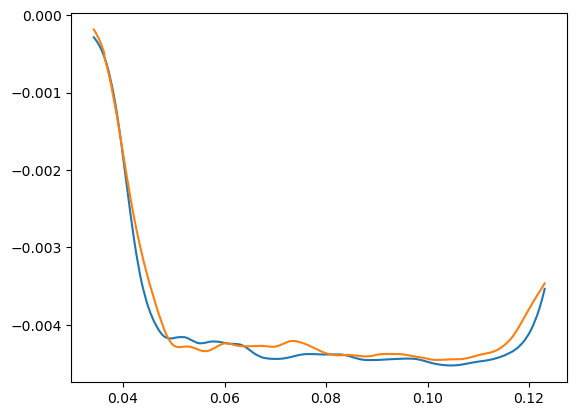

In [81]:
reflected_extracted2 = np.pad(reflected_extracted, (555,0), mode='constant')
transmitted_extracted2 = np.pad(transmitted_extracted, (1023,0), mode='constant')

import matplotlib.pyplot as plt
plt.plot(incident_extracted)
plt.plot(reflected_extracted2)
plt.plot(transmitted_extracted2)
plt.show()

start = 800
end = int(start + (pulse_data_points * .97))
incident_corrected = np.array(incident_extracted[start:end])
reflected_corrected = np.array(reflected_extracted2[start:end])
transmitted_corrected = np.array(transmitted_extracted2[start:end])
t = time[len(time) - len(incident_corrected):]


plt.plot(t, incident_corrected )
plt.plot(t, transmitted_corrected - reflected_corrected)
plt.show()

In [45]:
start = np.where(np.gradient(incident_extracted)[:np.argmin(np.gradient(incident_extracted))] >= -1e-6)[0][-1]

test = np.gradient(incident_extracted)[start]
print(start)
print(test)

793
-9.619107e-07


In [107]:
plt.plot(time[start:], incident_extracted[start:] )
plt.plot(time[start:], reflected_extracted[start:] )
plt.plot(time[start:], transmitted_extracted[start:] )
plt.show()

plt.plot(time, np.gradient(incident_extracted))
plt.plot(time[start], np.gradient(incident_extracted)[start], marker = "o")
plt.show()

NameError: name 'start' is not defined

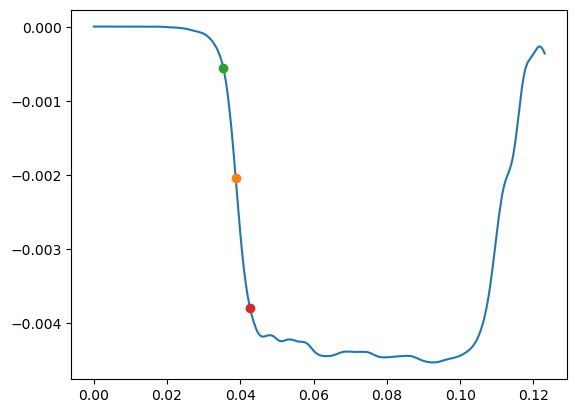

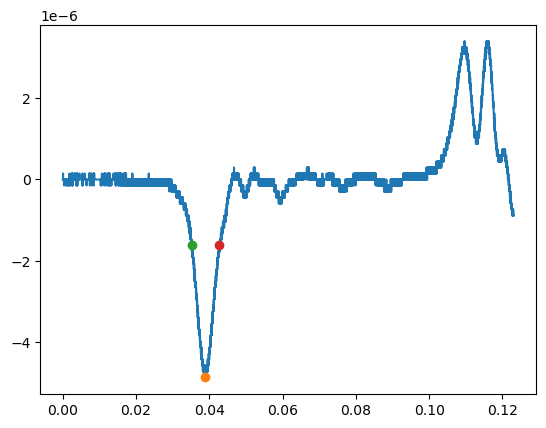

In [151]:
grad_inc = np.gradient(incident_extracted)
targetval = np.min(grad_inc) * 0.35
minidx = np.argmin(grad_inc)
fall_start = np.where(grad_inc[:minidx] >= targetval)[0][-1]
fall_end = np.where(grad_inc[minidx:] >= targetval)[0][0] + minidx


plt.plot(time, incident_extracted)
plt.plot(time[minidx], incident_extracted[minidx], marker="o")
plt.plot(time[fall_start], incident_extracted[fall_start], marker="o")
plt.plot(time[fall_end], incident_extracted[fall_end], marker="o")
plt.show()

plt.plot(time, grad_inc)
plt.plot(time[minidx], grad_inc[minidx], marker="o")
plt.plot(time[fall_start], grad_inc[fall_start], marker="o")
plt.plot(time[fall_end], grad_inc[fall_end], marker="o")
plt.show()

In [75]:
def det_pulse_correlation(incident, transmitted, reflected, idx):
    """
    Pearson r between incident[idx] and (T-R)[idx].
    """
    cand = transmitted - reflected
    inc  = incident
    inc  = inc[idx]
    cand = cand[idx]

    if inc.std() == 0 or cand.std() == 0:          # guard /0
        return -1.0
    return np.corrcoef(inc, cand)[0, 1]            # [-1, 1]
    

def det_bar_displacement(wave_speed, incident, transmitted, reflected):
    """
    Determines the bar displacement over the strain pulse signals
    """
    u2 = bar_wave_speed * (incident + reflected) # Two wave analysis
    u1 = bar_wave_speed * (transmitted) # One Wave Analysis

    return u1, u2

def det_eng_strain_rate(wave_speed, specimen_l, incident, transmitted, reflected):
    """
    Calculates the specimen eng strain rate from strain signals. 
    """
    sr_3w = (wave_speed / specimen_l) * (incident - reflected - transmitted)
    sr_1w = (2*wave_speed*reflected) / specimen_l

    return sr_3w, sr_1w

def det_eng_strain(wave_speed, specimen_l, incident, transmitted, reflected, time):
    """
    Calculates the specimen strain from strain signals. 
    """
    strain_3w = (wave_speed / specimen_l) * cumulative_trapezoid(
                    (incident- reflected - transmitted),
                    time, initial=0)
    
    strain_1w = ((2*wave_speed) / specimen_l) * cumulative_trapezoid(
                    reflected, time, initial=0)

    return strain_3w, strain_1w

Gen 00  |  best r = 0.74317  shifts = (1321, 3145)
Gen 01  |  best r = 0.75008  shifts = (3226, 1352)
Gen 02  |  best r = 0.76138  shifts = (3297, 1352)
Gen 03  |  best r = 0.76138  shifts = (3297, 1352)
Gen 04  |  best r = 0.76369  shifts = (3295, 1356)
Gen 05  |  best r = 0.76670  shifts = (3292, 1361)
Gen 06  |  best r = 0.76788  shifts = (3294, 1364)
Gen 07  |  best r = 0.76955  shifts = (3287, 1365)
Gen 08  |  best r = 0.77118  shifts = (3287, 1368)
Gen 09  |  best r = 0.77437  shifts = (3284, 1373)
Gen 10  |  best r = 0.77546  shifts = (3287, 1377)
Gen 11  |  best r = 0.77723  shifts = (3284, 1379)
Gen 12  |  best r = 0.78021  shifts = (3280, 1383)
Gen 13  |  best r = 0.78138  shifts = (3279, 1385)
Gen 14  |  best r = 0.78283  shifts = (3279, 1389)

Finished.
Best individual: (3279, 1389)  |  r = 0.78283


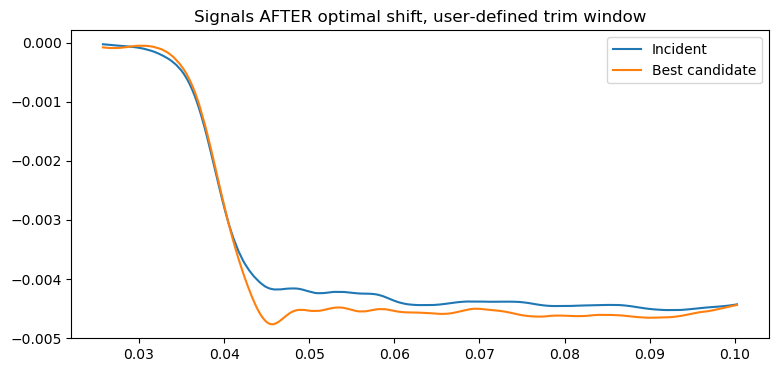

In [152]:
# ------------------------------------------------------------------
# 1.  FIND THE *LINEAR FALL* SECTION OF THE INCIDENT PULSE
# ------------------------------------------------------------------
grad_inc = np.gradient(incident_extracted)

targetval = np.min(grad_inc) * 0.35           # 30 % of the steepest slope
minidx    = np.argmin(grad_inc)               # steepest point

fall_start = np.where(grad_inc[:minidx] >= targetval)[0][-1]
fall_end   = np.where(grad_inc[minidx:] >= targetval)[0][0] + minidx

linear_idx = np.arange(fall_start, fall_end)  # indices we will correlate

# ------------------------------------------------------------------
# 2.  LOW‑LEVEL UTILITIES
# ------------------------------------------------------------------
def shift_signal(sig, shift):
    """Zero‑pad shift (positive = right, negative = left), length preserved."""
    if shift == 0:
        return sig
    n = len(sig)
    if shift > 0:
        return np.pad(sig, (shift, 0), mode="constant")[:n]
    else:                                     # shift < 0
        return np.pad(sig, (0, -shift), mode="constant")[-shift:]

def compute_fitness_physical(shift_t, shift_r,
                             incident, transmitted, reflected,
                             idx, time,         # linear window + full time
                             bar_c, specimen_L, # material constants
                             w):
    """
    Composite GA fitness built from:
      w['corr']  : pulse Pearson r  (larger better)
      w['u']     : displacement RMSE  (smaller better)
      w['sr']    : strain-rate RMSE  (smaller better)
      w['e']     : strain RMSE       (smaller better)
    'w' is a dict of non-negative weights.
    """
    # --- apply test shifts ---
    T = shift_signal(transmitted, shift_t)
    R = shift_signal(reflected,   shift_r)

    # -------- 1. shape correlation --------
    r = det_pulse_correlation(incident, T, R, idx)   # [-1, +1]

    # -------- 2. bar displacement ---------
    u1, u2 = det_bar_displacement(bar_c, incident, T, R)
    u_rmse = np.sqrt(np.mean((u1[idx] - u2[idx])**2))

    # -------- 3. strain rate --------------
    sr1, sr3 = det_eng_strain_rate(bar_c, specimen_L,
                                   incident, T, R)
    sr_rmse = np.sqrt(np.mean((sr1[idx] - sr3[idx])**2))

    # -------- 4. strain -------------------
    e1, e3 = det_eng_strain(bar_c, specimen_L,
                            incident, T, R, time)
    e_rmse = np.sqrt(np.mean((e1[idx] - e3[idx])**2))

    # -------- combine into a bigger-is-better fitness --------
    # Convert the three RMSEs (where 0 is best) into similarity scores
    # by using 1 / (1 + RMSE).  Then weight and sum.
    sim_u  = 1.0 / (1.0 + u_rmse)
    sim_sr = 1.0 / (1.0 + sr_rmse)
    sim_e  = 1.0 / (1.0 + e_rmse)

    fitness = (
        w['corr'] * r +
        w['u']    * sim_u +
        w['sr']   * sim_sr +
        w['e']    * sim_e
    )
    return fitness

def tournament_select(pop, fits, k=9):
    """Return one individual chosen by k‑way tournament."""
    sel = np.random.choice(len(pop), k, replace=False)
    best = sel[np.argmax([fits[i] for i in sel])]
    return pop[best]

# ------------------------------------------------------------------
# 3.  GA HYPERPARAMETERS
# ------------------------------------------------------------------
POP_SIZE       = 500
N_GENERATIONS  = 15
MUT_RATE       = 0.12
XOVER_RATE     = 0.8
SHIFT_BOUND    = 3500                        # ± indices to explore

# ------------------------------------------------------------------
# 4.  INITIAL POPULATION  (random integer shifts)
# ------------------------------------------------------------------
population = [
    (np.random.randint(0, SHIFT_BOUND + 1),
     np.random.randint(0, SHIFT_BOUND + 1))
    for _ in range(POP_SIZE)
]

best_individual = None
best_fitness    = -np.inf
weights = dict(corr=0.5, u=0.2, sr=0.2, e=0.1)

# ------------------------------------------------------------------
# 5.  MAIN GA LOOP
# ------------------------------------------------------------------
for gen in range(N_GENERATIONS):

    # --- fitness evaluation ---
    fitness = [
        compute_fitness_physical(sh_t, sh_r,
                        incident_extracted,
                        transmitted_extracted,
                        reflected_extracted,
                        linear_idx, time, 
                        bar_wave_speed, specimen_length, 
                        weights)
        for sh_t, sh_r in population
    ]

    # --- keep global best ---
    gen_best_idx = int(np.argmax(fitness))
    if fitness[gen_best_idx] > best_fitness:
        best_fitness = fitness[gen_best_idx]
        best_individual = population[gen_best_idx]

    print(f"Gen {gen:02d}  |  best r = {best_fitness:.5f}  "
          f"shifts = {best_individual}")

    # --- build next generation ---
    new_pop = []
    while len(new_pop) < POP_SIZE:
        p1 = tournament_select(population, fitness, k=15)
        p2 = tournament_select(population, fitness, k=15)

        # single‑point crossover on the *pair* of shifts
        if np.random.rand() < XOVER_RATE:
            child = (p1[0], p2[1]) if np.random.rand() < 0.5 else (p2[0], p1[1])
        else:
            child = p1

        # mutation (± 5 samples) on each gene
        sh_t, sh_r = child
        if np.random.rand() < MUT_RATE:
            sh_t += np.random.randint(-5, 6)
        if np.random.rand() < MUT_RATE:
            sh_r += np.random.randint(-5, 6)

        # clip to bounds and append
        new_pop.append((
            int(np.clip(sh_t, -SHIFT_BOUND, SHIFT_BOUND)),
            int(np.clip(sh_r, -SHIFT_BOUND, SHIFT_BOUND))
        ))

    population = new_pop

print("\nFinished.")
print(f"Best individual: {best_individual}  |  r = {best_fitness:.5f}")

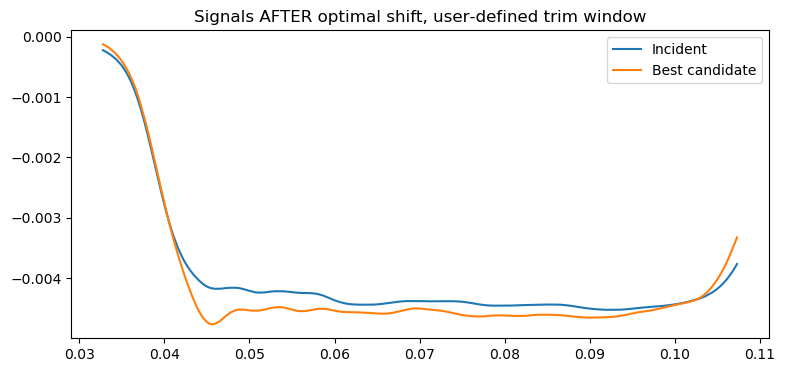

In [155]:
# ------------------------------------------------------------------
# POST‑GA TRIM  (optional, purely for visualisation or saving data)
# ------------------------------------------------------------------
pulse_start = 4200                                      # or user input
pulse_end   = int(pulse_start + (pulse_data_points * .97))

# Apply shifts *first* so the trimmed slices include the new alignment
best_shift_t, best_shift_r = best_individual

incident_corrected = incident_extracted[pulse_start:pulse_end]
transmitted_corrected = shift_signal(transmitted_extracted, best_shift_t)[pulse_start:pulse_end]
reflected_corrected = shift_signal(reflected_extracted,   best_shift_r)[pulse_start:pulse_end]
cand_plot = transmitted_corrected - reflected_corrected
t = time[pulse_start:pulse_end]

# quick check
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.plot(t, incident_corrected,  label="Incident")
plt.plot(t, cand_plot, label="Best candidate"); plt.legend()
plt.title("Signals AFTER optimal shift, user‑defined trim window")
plt.show()


In [156]:
if test_type == "SpecimenTest":
    pulse_correlation = go.Figure()
            
    pulse_correlation.add_trace(go.Scatter(x=t, y=(incident_corrected) , mode='lines', name='Incident', 
                                                            line=dict(color='royalblue', width=2))) 
    pulse_correlation.add_trace(go.Scatter(x=t, y=(transmitted_corrected - reflected_corrected) , mode='lines', name='Transmitted - Reflected', 
                                                            line=dict(color='red', width=2)))
    # Customize layout
    pulse_correlation.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                     title=dict(text="Pulse Correlation vs Time", x=0.5, y=0.95, xanchor="center",
                                                font=dict(size=20, color="black", family="Arial")),
                                     xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                                tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                                gridcolor="lightgrey", gridwidth=1),
                                     yaxis=dict(title=dict(text="Strain", font=dict(family="Arial", size=16, color="black")),
                                                tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                                gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                     legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                                 font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                                 bordercolor="black", borderwidth=2))
            
    # Display the interactive plot
    # Display the interactive plot
    fig_path = os.path.join(result_folder, experiment_name)
    os.makedirs(fig_path, exist_ok=True)
    pulse_correlation.write_html(os.path.join(fig_path, f"{experiment_name}_pulse_correlation.html"), include_plotlyjs='cdn')

In [157]:
alligned_pulse_fig = go.Figure()
        
alligned_pulse_fig.add_trace(go.Scatter(x=t, y=incident_corrected , mode='lines', name='Incident', 
                                                        line=dict(color='royalblue', width=2))) 
alligned_pulse_fig.add_trace(go.Scatter(x=t, y=transmitted_corrected , mode='lines', name='Transmitted', 
                                                        line=dict(color='red', width=2)))
if test_type == "SpecimenTest":
    alligned_pulse_fig.add_trace(go.Scatter(x=t, y=reflected_corrected , mode='lines', name='Reflected', 
                                                            line=dict(color='green', width=2))) 
# Customize layout
alligned_pulse_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                 title=dict(text="Extracted Strain Signals vs Time", x=0.5, y=0.95, xanchor="center",
                                            font=dict(size=20, color="black", family="Arial")),
                                 xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                            tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                            gridcolor="lightgrey", gridwidth=1),
                                 yaxis=dict(title=dict(text="Strain", font=dict(family="Arial", size=16, color="black")),
                                            tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                            gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                 legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                             font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                             bordercolor="black", borderwidth=2))
        
# Display the interactive plot
# Display the interactive plot
fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)
alligned_pulse_fig.write_html(os.path.join(fig_path, f"{experiment_name}_aligned_pulse.html"), include_plotlyjs='cdn')

In [158]:
u1 = bar_wave_speed * (incident_corrected + reflected_corrected)
u2 = bar_wave_speed * (transmitted_corrected)

sims = pd.DataFrame()
sims["Time (ms)"] = time
sims["Velocity (mm/ms)"] = bar_wave_speed * incident_extracted 
sims.to_csv(os.path.join(fig_path, f"{experiment_name}_initial_vel.csv"), index=False)

In [159]:
bar_displacement_fig = go.Figure()
        
bar_displacement_fig.add_trace(go.Scatter(x=time, y=-u1 , mode='lines', name='Front Surface', line=dict(color='blue', width=2))) 
#bar_displacement_fig.add_trace(go.Scatter(x=time, y=-u3 , mode='lines', name='Front Surface?', line=dict(color='blue', width=2)))
bar_displacement_fig.add_trace(go.Scatter(x=time, y=-u2 , mode='lines', name='Back Surface', line=dict(color='red', width=2)))

# Customize layout
bar_displacement_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                   title=dict(text="Bar Displacement vs Time", x=0.5, y=0.95, xanchor="center",
                                              font=dict(size=20, color="black", family="Arial")),
                                   xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                              tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                              gridcolor="lightgrey", gridwidth=1),
                                   yaxis=dict(title=dict(text="Velocity (mm/ms)", font=dict(family="Arial", size=16, color="black")),
                                              tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                              gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                   legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                               font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                               bordercolor="black", borderwidth=2))
        
# Display the interactive plot
# Display the interactive plot
fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)
bar_displacement_fig.write_html(os.path.join(fig_path, f"{experiment_name}_bar_disp.html"), include_plotlyjs='cdn')

In [160]:
F1 = bar_cross_section * (bar_elastic_modulus/1000) * (incident_corrected + reflected_corrected)
F2 = bar_cross_section * (bar_elastic_modulus/1000) * (transmitted_corrected)

In [161]:
bar_forces_fig = go.Figure()
        
bar_forces_fig.add_trace(go.Scatter(x=time, y=-F1 , mode='lines', name='Front Surface', line=dict(color='blue', width=2))) 
bar_forces_fig.add_trace(go.Scatter(x=time, y=-F2 , mode='lines', name='Back Surface', line=dict(color='red', width=2)))

# Customize layout
bar_forces_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Pulse Force vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=20, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Force (kN)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Strain Pulses", x=1.0, y=1.0, 
                                         font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                         bordercolor="black", borderwidth=2))

        
# Display the interactive plot
# Display the interactive plot
fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)
bar_forces_fig.write_html(os.path.join(fig_path, f"{experiment_name}_force.html"), include_plotlyjs='cdn')

In [162]:
strain_rate_1 = (bar_wave_speed / specimen_length) * (incident_corrected - reflected_corrected - transmitted_corrected)
strain_rate_2 = (2*bar_wave_speed*reflected_corrected) / specimen_length

In [163]:
eng_strain_rate_fig = go.Figure()
        
eng_strain_rate_fig.add_trace(go.Scatter(x=time, y=-strain_rate_1*1e3 , mode='lines', name='3-Wave Method', line=dict(color='blue', width=2))) 
eng_strain_rate_fig.add_trace(go.Scatter(x=time, y=strain_rate_2*1e3, mode='lines', name='1-Wave Method', line=dict(color='red', width=2)))

# Customize layout
eng_strain_rate_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                  title=dict(text="Engineering Strain Rate vs Time", x=0.5, y=0.95, xanchor="center",
                                             font=dict(size=20, color="black", family="Arial")),
                                  xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                             tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                             gridcolor="lightgrey", gridwidth=1),
                                  yaxis=dict(title=dict(text="Engineering Strain Rate (1/s)", font=dict(family="Arial", size=16, color="black")),
                                             tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                             gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                  legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                              font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                              bordercolor="black", borderwidth=2))        
# Display the interactive plot
# Display the interactive plot
fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)
eng_strain_rate_fig.write_html(os.path.join(fig_path, f"{experiment_name}_eng_strain_rate.html"), include_plotlyjs='cdn')

In [164]:
# Using Dispersion Corrected Pulses
strain_1 = (bar_wave_speed / specimen_length) * cumulative_trapezoid(
                (incident_corrected - reflected_corrected - transmitted_corrected),
                t, initial=0)

strain_2 = ((2*bar_wave_speed) / specimen_length) * cumulative_trapezoid(
                reflected_corrected,
                t, initial=0)


In [165]:
eng_strain_fig = go.Figure()
        
eng_strain_fig.add_trace(go.Scatter(x=time, y=-strain_1 , mode='lines', name='3-Wave Method', line=dict(color='blue', width=2))) 
eng_strain_fig.add_trace(go.Scatter(x=time, y=strain_2, mode='lines', name='1-Wave Method', line=dict(color='red', width=2)))

# Customize layout
eng_strain_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Engineering Strain vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=20, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Engineering Strain (mm/mm)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                         font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                         bordercolor="black", borderwidth=2))

        
# Display the interactive plot# Display the interactive plot
fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)
eng_strain_fig.write_html(os.path.join(fig_path, f"{experiment_name}_eng_strain.html"), include_plotlyjs='cdn')


In [166]:
# Using Dispersion Corrected Pulses
sigma_1 = (bar_elastic_modulus/1000) * (bar_cross_section / specimen_cross) * (incident_corrected + reflected_corrected)
sigma_2 = (bar_elastic_modulus/1000) * (bar_cross_section / specimen_cross) * (transmitted_corrected)


In [167]:
eng_stress_fig = go.Figure()
        
eng_stress_fig.add_trace(go.Scatter(x=time, y=-sigma_1*1e3 , mode='lines', name='2-Wave Method', line=dict(color='blue', width=2))) 
eng_stress_fig.add_trace(go.Scatter(x=time, y=-sigma_2*1e3, mode='lines', name='1-Wave Method', line=dict(color='red', width=2)))

# Customize layout
eng_stress_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                             title=dict(text="Engineering Stress vs Time", x=0.5, y=0.95, xanchor="center",
                                        font=dict(size=20, color="black", family="Arial")),
                             xaxis=dict(title=dict(text="Time (ms)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridcolor="lightgrey", gridwidth=1),
                             yaxis=dict(title=dict(text="Engineering Stress (MPa)", font=dict(family="Arial", size=16, color="black")),
                                        tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                        gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                             legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                         font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                         bordercolor="black", borderwidth=2))
        
# Display the interactive plot
# Display the interactive plot# Display the interactive plot
fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)
eng_stress_fig.write_html(os.path.join(fig_path, f"{experiment_name}_eng_stress.html"), include_plotlyjs='cdn')

In [168]:
# Stress - Strain 

eng_stress_strain_fig = go.Figure()
        
eng_stress_strain_fig.add_trace(go.Scatter(x=-strain_1, y=-sigma_1*1e3 , mode='lines', name='2-Wave Method', line=dict(color='blue', width=2)))
eng_stress_strain_fig.add_trace(go.Scatter(x=strain_2, y=-sigma_2*1e3, mode='lines', name='1-Wave Method', line=dict(color='red', width=2)))

# Customize layout
eng_stress_strain_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                    title=dict(text="Engineering Stress vs Strain", x=0.5, y=0.95, xanchor="center",
                                               font=dict(size=20, color="black", family="Arial")),
                                    xaxis=dict(title=dict(text="Strain (mm/mm)", font=dict(family="Arial", size=16, color="black")),
                                               tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                               gridcolor="lightgrey", gridwidth=1),
                                    yaxis=dict(title=dict(text="Engineering Stress (MPa)", font=dict(family="Arial", size=16, color="black")),
                                               tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                               gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                    legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                                font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                                bordercolor="black", borderwidth=2))

        
# Display the interactive plot
# Display the interactive plot# Display the interactive plot
fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)
eng_stress_strain_fig.write_html(os.path.join(fig_path, f"{experiment_name}_eng_stress_strain.html"), include_plotlyjs='cdn')


In [169]:
# True Stress True Strain Series

true_strain_1 = np.log(1 + strain_1)
true_strain_2 = np.log(1 + strain_2)
true_stress_1 = sigma_1 * (1 + strain_1)
true_stress_2 = sigma_2 * (1 + strain_1)

In [170]:
true_stress_strain_fig = go.Figure()
        
true_stress_strain_fig.add_trace(go.Scatter(x=-true_strain_1 , y=-true_stress_1*1e3 , mode='lines', name='2-Wave Method', line=dict(color='blue', width=2)))
true_stress_strain_fig.add_trace(go.Scatter(x=-true_strain_1 , y=-true_stress_2*1e3, mode='lines', name='1-Wave Method', line=dict(color='red', width=2)))
# Customize layout
true_stress_strain_fig.update_layout(width=1100, height=600, plot_bgcolor="#F5F5F5", paper_bgcolor="#FFFFFF",
                                     title=dict(text="True Stress vs Strain", x=0.5, y=0.95, xanchor="center",
                                                font=dict(size=20, color="black", family="Arial")),
                                     xaxis=dict(title=dict(text="True Strain (mm/mm)", font=dict(family="Arial", size=16, color="black")),
                                                tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                                gridcolor="lightgrey", gridwidth=1),
                                     yaxis=dict(title=dict(text="True Stress (MPa)", font=dict(family="Arial", size=16, color="black")),
                                                tickfont=dict(size=16, color="black", family="Arial"), showgrid=True,
                                                gridwidth=1, gridcolor="lightgrey", zeroline=True, zerolinewidth=2, zerolinecolor="grey"),
                                     legend=dict(title="Strain Pulses", x=1.0, y=1.0,
                                                 font=dict(size=12, color="black", family="Arial"), bgcolor="#FFFFFF",
                                                 bordercolor="black", borderwidth=2))
        
# Display the interactive plot
# Display the interactive plot# Display the interactive plot
fig_path = os.path.join(result_folder, experiment_name)
os.makedirs(fig_path, exist_ok=True)
true_stress_strain_fig.write_html(os.path.join(fig_path, f"{experiment_name}_true_stress_strain.html"), include_plotlyjs='cdn')

In [171]:
# Calculate True strains for all signals

In [172]:
results_df = pd.DataFrame()

results_df["Time"] = t.astype(np.float32)
results_df["Incident"] = incident_corrected
results_df["Reflected"] = reflected_corrected
results_df["Transmitted"] = transmitted_corrected

results_df["Front Displacement"] = u1
results_df["Back Displacement"] = u2
results_df["Front Force"]= F1 
results_df["Back Force"]= F2
results_df["Strain Rate 3W"]= strain_rate_1
results_df["Strain Rate 1W"]= strain_rate_2
results_df["Engineering Strain 3W"] = strain_1.astype(np.float32)
results_df["Engineering Strain 1W"] = strain_2.astype(np.float32)
results_df["Engineering Stress 2W"] = sigma_1
results_df["Engineering Stress 1W"] = sigma_2
results_df["True Strain 3W"] = true_strain_1.astype(np.float32)
results_df["True Strain 1W"] = true_strain_2.astype(np.float32)
results_df["True Stress 2W"] = true_stress_1.astype(np.float32)
results_df["True Stress 1W"] = true_stress_2.astype(np.float32)

results_df.to_csv(os.path.join(fig_path, f"{experiment_name}_secondary_data.csv"))




